In [1]:

import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report


class DropPath(layers.Layer):
    """Stochastic Depth (DropPath)."""
    def __init__(self, drop_prob=0., **kwargs):
        super().__init__(**kwargs)
        self.drop_prob = drop_prob

    def call(self, x, training=None):
        if (not training) or (self.drop_prob == 0.):
            return x
        keep_prob = 1.0 - self.drop_prob
        shape = (tf.shape(x)[0],) + (1,) * (len(x.shape) - 1)
        random_tensor = keep_prob + tf.random.uniform(shape, dtype=x.dtype)
        binary_tensor = tf.floor(random_tensor)
        return tf.divide(x, keep_prob) * binary_tensor

# Patch Embedding (Conv)

class PatchEmbed(layers.Layer):
    def __init__(self, patch_size=4, embed_dim=96, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size
        self.proj = layers.Conv2D(filters=embed_dim, kernel_size=patch_size, strides=patch_size, padding='valid')
        self.norm = layers.LayerNormalization(epsilon=1e-6)

    def call(self, x):
        # x: (B, H, W, C)
        x = self.proj(x)                  # (B, H/ps, W/ps, embed_dim)
        B = tf.shape(x)[0]
        H = tf.shape(x)[1]
        W = tf.shape(x)[2]
        C = tf.shape(x)[3]
        x = tf.reshape(x, (B, H * W, C))  # (B, N, C)
        x = self.norm(x)
        return x


# MLP used inside blocks
def MLP(hidden_dim, out_dim, drop=0.0):
    return keras.Sequential([
        layers.Dense(hidden_dim),
        layers.Activation('gelu'),
        layers.Dropout(drop),
        layers.Dense(out_dim),
        layers.Dropout(drop),
    ])

# Window partition / reverse helpers (use TF ops)
def window_partition(x, window_size):
    # x: (B, H, W, C)
    Wh, Ww = window_size
    B = tf.shape(x)[0]
    H = tf.shape(x)[1]
    W = tf.shape(x)[2]
    C = tf.shape(x)[3]
    x = tf.reshape(x, (B, H // Wh, Wh, W // Ww, Ww, C))
    x = tf.transpose(x, perm=(0,1,3,2,4,5))  # B, H//Wh, W//Ww, Wh, Ww, C
    windows = tf.reshape(x, (-1, Wh * Ww, C))
    return windows

def window_reverse(windows, window_size, H, W):
    # windows: (num_windows*B, Wh*Ww, C)
    Wh, Ww = window_size
    num_windows_per_image = (H // Wh) * (W // Ww)
    B = tf.shape(windows)[0] // num_windows_per_image
    x = tf.reshape(windows, (B, H // Wh, W // Ww, Wh, Ww, -1))
    x = tf.transpose(x, perm=(0,1,3,2,4,5))
    x = tf.reshape(x, (B, H, W, -1))
    return x


# Window Attention Layer

class WindowAttention(layers.Layer):
    def __init__(self, dim, window_size=(7,7), num_heads=8, qkv_bias=True, attn_drop=0., proj_drop=0., **kwargs):
        super().__init__(**kwargs)
        self.dim = dim
        self.window_size = window_size
        self.num_heads = num_heads
        self.head_dim = dim // num_heads
        self.scale = self.head_dim ** -0.5

        self.qkv = layers.Dense(dim * 3, use_bias=qkv_bias)
        self.attn_drop = layers.Dropout(attn_drop)
        self.proj = layers.Dense(dim)
        self.proj_drop = layers.Dropout(proj_drop)

        # relative position bias table (trainable)
        Wh, Ww = window_size
        num_rel = (2*Wh - 1) * (2*Ww - 1)
        self.relative_position_bias_table = self.add_weight(
            shape=(num_rel, num_heads), initializer='zeros', trainable=True, name='rel_pos_bias'
        )

        # compute relative position index (constant)
        coords_h = np.arange(Wh)
        coords_w = np.arange(Ww)
        coords = np.stack(np.meshgrid(coords_h, coords_w, indexing='ij'))  # 2, Wh, Ww
        coords_flatten = coords.reshape(2, -1)
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]
        relative_coords = relative_coords.transpose(1, 2, 0)  # N, N, 2
        relative_coords[:, :, 0] += Wh - 1
        relative_coords[:, :, 1] += Ww - 1
        relative_coords[:, :, 0] *= 2 * Ww - 1
        relative_position_index = relative_coords.sum(-1)  # N, N
        self.relative_position_index = tf.convert_to_tensor(relative_position_index, dtype=tf.int32)

    def call(self, x, mask=None):
        B_, N, C = tf.shape(x)[0], tf.shape(x)[1], tf.shape(x)[2]
        qkv = self.qkv(x)  # (B_, N, 3*C)
        qkv = tf.reshape(qkv, (B_, N, 3, self.num_heads, self.head_dim))
        qkv = tf.transpose(qkv, perm=(2, 0, 3, 1, 4))  # 3, B_, heads, N, head_dim
        q, k, v = qkv[0], qkv[1], qkv[2]  # each: (B_, heads, N, head_dim)

        q = q * self.scale
        attn = tf.matmul(q, k, transpose_b=True)  # (B_, heads, N, N)

        # add relative position bias
        WhWw = self.window_size[0] * self.window_size[1]
        relative_position_bias = tf.gather(self.relative_position_bias_table, tf.reshape(self.relative_position_index, [-1]))
        relative_position_bias = tf.reshape(relative_position_bias, (WhWw, WhWw, -1))
        relative_position_bias = tf.transpose(relative_position_bias, perm=(2,0,1))  # heads, N, N
        attn = attn + tf.expand_dims(relative_position_bias, axis=0)

        if mask is not None:
            nW = tf.shape(mask)[0]
            # reshape attn to (B_ // nW, nW, heads, N, N)
            attn = tf.reshape(attn, (-1, nW, self.num_heads, N, N))
            attn = attn + tf.expand_dims(tf.expand_dims(mask, 1), 0)
            attn = tf.reshape(attn, (-1, self.num_heads, N, N))

        attn = tf.nn.softmax(attn, axis=-1)
        attn = self.attn_drop(attn)
        x = tf.matmul(attn, v)  # (B_, heads, N, head_dim)
        x = tf.transpose(x, perm=(0,2,1,3))
        x = tf.reshape(x, (B_, N, C))
        x = self.proj(x)
        x = self.proj_drop(x)
        return x


# Swin Block

class SwinBlock(layers.Layer):
    def __init__(self, dim, input_resolution, num_heads, window_size=7, shift_size=0,
                 mlp_ratio=4., qkv_bias=True, drop=0., attn_drop=0., drop_path=0., **kwargs):
        """
        input_resolution: tuple of ints (H, W) - must be known integers when creating layer
        """
        super().__init__(**kwargs)
        assert isinstance(input_resolution[0], (int, np.integer)) and isinstance(input_resolution[1], (int, np.integer)), \
            "input_resolution must be integers"
        self.dim = dim
        self.input_resolution = input_resolution
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size if shift_size < window_size else 0
        self.mlp_ratio = mlp_ratio

        self.norm1 = layers.LayerNormalization(epsilon=1e-6)
        self.attn = WindowAttention(dim=dim, window_size=(window_size, window_size),
                                    num_heads=num_heads, qkv_bias=qkv_bias,
                                    attn_drop=attn_drop, proj_drop=drop)
        self.drop_path = DropPath(drop_path) if drop_path > 0. else layers.Activation('linear')
        self.norm2 = layers.LayerNormalization(epsilon=1e-6)
        self.mlp = MLP(int(dim * mlp_ratio), dim, drop=drop)

        # prepare attention mask for shifted windows if needed (use numpy since H,W int)
        H, W = self.input_resolution
        if self.shift_size > 0:
            img_mask = np.zeros((1, H, W, 1), dtype=np.int32)
            cnt = 0
            h_slices = (slice(0, -window_size), slice(-window_size, -self.shift_size), slice(-self.shift_size, None))
            w_slices = (slice(0, -window_size), slice(-window_size, -self.shift_size), slice(-self.shift_size, None))
            for h in h_slices:
                for w in w_slices:
                    img_mask[:, h, w, :] = cnt
                    cnt += 1
            # partition and compute mask difference
            # convert to TF tensor and use helper partitioning (works with constant shapes)
            mask_windows = window_partition(tf.convert_to_tensor(img_mask, dtype=tf.float32), (window_size, window_size))
            mask_windows = tf.reshape(mask_windows, (-1, window_size * window_size))
            attn_mask = tf.expand_dims(mask_windows, 1) - tf.expand_dims(mask_windows, 2)
            attn_mask = tf.where(attn_mask != 0, tf.constant(-100.0), tf.constant(0.0))
            # keep as a TF variable (non-trainable)
            self.attn_mask = tf.Variable(attn_mask, trainable=False, dtype=tf.float32)
        else:
            self.attn_mask = None

    def call(self, x, training=False):
        H, W = self.input_resolution
        B = tf.shape(x)[0]
        N = tf.shape(x)[1]
        C = tf.shape(x)[2]

        shortcut = x
        x = self.norm1(x)
        x = tf.reshape(x, (B, H, W, C))

        # cyclic shift
        if self.shift_size > 0:
            shifted_x = tf.roll(x, shift=[-self.shift_size, -self.shift_size], axis=[1, 2])
        else:
            shifted_x = x

        # partition windows
        x_windows = window_partition(shifted_x, (self.window_size, self.window_size))  # (num_windows*B, Wh*Ww, C)
        attn_windows = self.attn(x_windows, mask=self.attn_mask)  # (num_windows*B, Wh*Ww, C)

        # merge windows
        shifted_x = window_reverse(attn_windows, (self.window_size, self.window_size), H, W)
        if self.shift_size > 0:
            x = tf.roll(shifted_x, shift=[self.shift_size, self.shift_size], axis=[1, 2])
        else:
            x = shifted_x
        x = tf.reshape(x, (B, N, C))

        # FFN and residuals with DropPath
        x = shortcut + self.drop_path(x, training=training)
        x = x + self.drop_path(self.mlp(self.norm2(x)), training=training)
        return x


# Patch Merging (downsample)

class PatchMerging(layers.Layer):
    def __init__(self, input_resolution, dim, **kwargs):
        super().__init__(**kwargs)
        assert isinstance(input_resolution[0], (int, np.integer)) and isinstance(input_resolution[1], (int, np.integer)), \
            "input_resolution must be integers"
        self.input_resolution = input_resolution
        self.dim = dim
        self.norm = layers.LayerNormalization(epsilon=1e-6)
        self.reduction = layers.Dense(2 * dim, use_bias=False)

    def call(self, x):
        # x: (B, H*W, C)
        H, W = self.input_resolution
        B = tf.shape(x)[0]
        C = tf.shape(x)[2]
        x = tf.reshape(x, (B, H, W, C))

        x0 = x[:, 0::2, 0::2, :]  # B H/2 W/2 C
        x1 = x[:, 1::2, 0::2, :]
        x2 = x[:, 0::2, 1::2, :]
        x3 = x[:, 1::2, 1::2, :]
        x = tf.concat([x0, x1, x2, x3], axis=-1)  # B H/2 W/2 4*C
        x = tf.reshape(x, (B, -1, 4 * C))
        x = self.norm(x)
        x = self.reduction(x)  # B, H/2*W/2, 2*C
        return x


# Build Swin Transformer backbone
def build_swin_transformer(
    input_shape=(224,224,3),
    patch_size=4,
    num_classes=5,
    embed_dim=96,
    depths=(2,2,6,2),
    num_heads=(3,6,12,24),
    window_size=7,
    mlp_ratio=4.,
    drop_rate=0.0,
    attn_drop_rate=0.0,
    drop_path_rate=0.1,
    small=False
):
    # Validate depths/num_heads lengths
    assert len(depths) == len(num_heads), "depths and num_heads must have same length"

    # compute initial patch resolution (integers)
    H_img, W_img = input_shape[0], input_shape[1]
    assert H_img % patch_size == 0 and W_img % patch_size == 0, "Image size must be divisible by patch_size"
    H = H_img // patch_size
    W = W_img // patch_size

    img_input = layers.Input(shape=input_shape)

    # patch embedding
    x = PatchEmbed(patch_size=patch_size, embed_dim=embed_dim)(img_input)  # (B, H*W, embed_dim)

    total_blocks = sum(depths)
    dpr = list(np.linspace(0.0, drop_path_rate, total_blocks))

    cur_resolution = (H, W)
    cur_dim = embed_dim
    block_idx = 0
    cur = x

    for stage_idx, (stage_depth, n_head) in enumerate(zip(depths, num_heads)):
        for i in range(stage_depth):
            shift = 0 if (i % 2 == 0) else window_size // 2
            cur = SwinBlock(dim=cur_dim, input_resolution=cur_resolution, num_heads=n_head,
                            window_size=window_size, shift_size=shift, mlp_ratio=mlp_ratio,
                            qkv_bias=True, drop=drop_rate, attn_drop=attn_drop_rate,
                            drop_path=dpr[block_idx])(cur)
            block_idx += 1

        # patch merging except last stage
        if stage_idx < len(depths) - 1:
            cur = PatchMerging(input_resolution=cur_resolution, dim=cur_dim)(cur)
            cur_resolution = (cur_resolution[0] // 2, cur_resolution[1] // 2)
            cur_dim = cur_dim * 2

    # final head
    x = layers.LayerNormalization(epsilon=1e-6)(cur)
    x = layers.GlobalAveragePooling1D()(x)
    out = layers.Dense(num_classes, activation='softmax')(x)

    model = keras.Model(img_input, out)
    return model


In [2]:
# Helper: create lighter config if GPU limited
def create_model(input_shape=(224,224,3), num_classes=5, small=True):
    if small:
        return build_swin_transformer(input_shape=input_shape, patch_size=4, num_classes=num_classes,
                                      embed_dim=64, depths=(2,2,2,2), num_heads=(2,4,8,16),
                                      window_size=7, drop_rate=0.1, drop_path_rate=0.1)
    else:
        return build_swin_transformer(input_shape=input_shape, patch_size=4, num_classes=num_classes,
                                      embed_dim=96, depths=(2,2,6,2), num_heads=(3,6,12,24),
                                      window_size=7, drop_rate=0.1, drop_path_rate=0.2)

In [3]:

# === Training / Data pipeline utilities ===

def prepare_datasets_from_numpy(x_data, y_data, val_split=0.2, batch_size=32, buffer_size=2048):
    """
    Prepares TF Datasets from pre-augmented numpy arrays.
    It only handles splitting, normalization, shuffling, and batching.
    Augmentation is assumed to be done offline.
    """
    # x_data: numpy images (N, H, W, 3) ; y_data: one-hot labels
    N = len(x_data)
    idx = int(N * (1 - val_split))
    x_train, y_train = x_data[:idx], y_data[:idx]
    x_val, y_val = x_data[idx:], y_data[idx:]
    print(f"Data split: {len(x_train)} for training, {len(x_val)} for validation.")

    def _prep(image, label):
        return image, label

    # Create the training dataset
    train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    train_ds = train_ds.shuffle(buffer_size)
    train_ds = train_ds.map(_prep, num_parallel_calls=tf.data.AUTOTUNE)
    train_ds = train_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    # Create the validation dataset
    val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val))
    val_ds = val_ds.map(_prep, num_parallel_calls=tf.data.AUTOTUNE)
    val_ds = val_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return train_ds, val_ds


In [4]:

# === Training orchestration ===
def compile_and_train(model, train_ds, val_ds,
                      lr=1e-4, epochs=100, checkpoint_path='best_model.h5',
                      patience_es=10, reduce_lr_patience=25):
    # compile
    model.compile(
        optimizer=keras.optimizers.AdamW(learning_rate=lr),
        loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
        metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=2, name='top_2_accuracy')]
    )

    callbacks = [
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience_es, restore_best_weights=True, verbose=1),
        keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1),
        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=reduce_lr_patience, min_lr=1e-7, verbose=1)
    ]

    history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=callbacks)
    return history



In [5]:


# === Plot / Eval helpers ===
def plot_history(history):
    # Plot Loss and Main Accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('epoch'); plt.ylabel('loss'); plt.legend(); plt.grid(True)
    plt.title('Training and Validation Loss')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.xlabel('epoch'); plt.ylabel('accuracy'); plt.legend(); plt.grid(True)
    plt.title('Training and Validation Accuracy')
    plt.show()

    # Plot Top-2 Accuracy if it exists
    if 'top_2_accuracy' in history.history:
        plt.figure(figsize=(6, 5))
        plt.plot(history.history['top_2_accuracy'], label='train_top_2_acc')
        plt.plot(history.history['val_top_2_accuracy'], label='val_top_2_acc')
        plt.xlabel('epoch'); plt.ylabel('Top-2 Accuracy'); plt.legend(); plt.grid(True)
        plt.title('Training and Validation Top-2 Accuracy')
        plt.show()

def evaluate_and_report(model, ds, class_names=None):
    # predict and flatten true labels
    y_true = []
    y_pred = []
    for images, labels in ds:
        preds = model.predict(images)
        y_pred.extend(np.argmax(preds, axis=1))
        y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    print("Classification Report:")
    if class_names is None:
        print(classification_report(y_true, y_pred, zero_division=0))
    else:
        print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()
    ticks = np.arange(len(cm))
    if class_names is None:
        plt.xticks(ticks, ticks)
        plt.yticks(ticks, ticks)
    else:
        plt.xticks(ticks, class_names, rotation=45)
        plt.yticks(ticks, class_names)
    plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Confusion Matrix')
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j], ha='center', va='center', color='black')
    plt.show()

In [6]:
from sklearn.metrics import roc_curve, auc

def full_evaluation_report_and_roc(model, ds, class_names):
    """
    Generates a comprehensive report including per-class metrics (Sensitivity, Specificity, etc.)
    and plots the multi-class ROC curve.
    """
    # --- 1. Gather Predictions and True Labels ---
    y_true_one_hot = []
    y_pred_probs = []
    print("Gathering predictions from the dataset for full evaluation...")
    for images, labels in ds:
        preds = model.predict(images, verbose=0)
        y_pred_probs.append(preds)
        y_true_one_hot.append(labels.numpy())

    y_pred_probs = np.concatenate(y_pred_probs, axis=0)
    y_true_one_hot = np.concatenate(y_true_one_hot, axis=0)
    y_pred_classes = np.argmax(y_pred_probs, axis=1)
    y_true_classes = np.argmax(y_true_one_hot, axis=1)

    print("\n" + "="*50)
    print(" " * 15 + "Full Evaluation Report")
    print("="*50)

    # --- 2. Standard Classification Report ---
    print("\n1. Standard Classification Report:\n")
    print(classification_report(y_true_classes, y_pred_classes, target_names=class_names, zero_division=0))

    # --- 3. Per-Class Metrics ---
    print("\n2. Detailed Per-Class Metrics:\n")
    cm = confusion_matrix(y_true_classes, y_pred_classes)
    for i, name in enumerate(class_names):
        tp = cm[i, i]
        fn = np.sum(cm[i, :]) - tp
        fp = np.sum(cm[:, i]) - tp
        tn = np.sum(cm) - (tp + fn + fp)

        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0

        print(f"--- Class: {name} ---")
        print(f"  - Sensitivity (Recall): {sensitivity:.4f}")
        print(f"  - Specificity:          {specificity:.4f}")
        print(f"  - Precision:            {precision:.4f}")
        print("-" * 25)

    # --- 4. ROC Curve and AUC ---
    print("\n3. ROC Curve Analysis:\n")
    fpr, tpr, roc_auc = dict(), dict(), dict()
    for i in range(len(class_names)):
        fpr[i], tpr[i], _ = roc_curve(y_true_one_hot[:, i], y_pred_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(10, 8))
    colors = ['blue', 'red', 'green', 'orange', 'purple']
    for i, color in zip(range(len(class_names)), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC for {class_names[i]} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Chance')
    plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (1 - Specificity)'); plt.ylabel('True Positive Rate (Sensitivity)')
    plt.title('Multi-Class ROC Curve'); plt.legend(loc="lower right"); plt.grid(True)
    plt.show()
    print("="*50)

In [7]:
from google.colab import drive
drive.mount('/content/drive')
DRIVE_LOAD_DIR = "/content/drive/MyDrive/Colab_Datasets/APTOS_Processed_Augmented"


print(f"Loading data from {DRIVE_LOAD_DIR}...")

x = np.load(os.path.join(DRIVE_LOAD_DIR, 'X_train.npy'))
y = np.load(os.path.join(DRIVE_LOAD_DIR, 'y_train_one_hot.npy'))
print(f"Data loaded successfully. Shapes: x={x.shape}, y={y.shape}")
print("Before oversampling class distribution:", np.argmax(y, axis=1).tolist()[:10])

labels = np.argmax(y, axis=1)

unique_classes, counts = np.unique(labels, return_counts=True)
max_count = counts.max()

new_x, new_y = [], []
for cls, count in zip(unique_classes, counts):
    cls_idx = np.where(labels == cls)[0]
    reps = int(np.ceil(max_count / count))
    oversampled_idx = np.random.choice(cls_idx, size=max_count, replace=True)
    new_x.append(x[oversampled_idx])
    new_y.append(y[oversampled_idx])

x_oversampled = np.concatenate(new_x, axis=0)
y_oversampled = np.concatenate(new_y, axis=0)

perm = np.random.permutation(len(x_oversampled))
x_oversampled = x_oversampled[perm]
y_oversampled = y_oversampled[perm]

print(f"After oversampling: x shape = {x_oversampled.shape}, distribution = {np.unique(np.argmax(y_oversampled,axis=1), return_counts=True)}")
train_ds, val_ds = prepare_datasets_from_numpy(x_oversampled, y_oversampled, val_split=0.2, batch_size=16)


model = create_model(input_shape=(224,224,3), num_classes=5, small=False)
model.summary()



Mounted at /content/drive
Loading data from /content/drive/MyDrive/Colab_Datasets/APTOS_Processed_Augmented...
Data loaded successfully. Shapes: x=(5860, 224, 224, 3), y=(5860, 5)
Before oversampling class distribution: [2, 2, 1, 1, 4, 4, 0, 0, 0, 0]
After oversampling: x shape = (14340, 224, 224, 3), distribution = (array([0, 1, 2, 3, 4]), array([2868, 2868, 2868, 2868, 2868]))
Data split: 11472 for training, 2868 for validation.


Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ patch_embed (PatchEmbed)        │ (None, 3136, 96)       │         4,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ swin_block (SwinBlock)          │ (None, 3136, 96)       │       112,347 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ swin_block_1 (SwinBlock)        │ (None, 3136, 96)       │       112,347 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ patch_merging (PatchMerging)    │ (None, None, 192)      │        74,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ swin_block_2 (SwinBlock)        │ (None, None, 192)      │       445,878 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ swin_block_3 (SwinBlock)        │ (None, None, 192)      │       445,878 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ patch_merging_1 (PatchMerging)  │ (None, None, 384)      │       296,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ swin_block_4 (SwinBlock)        │ (None, None, 384)      │     1,776,492 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ swin_block_5 (SwinBlock)        │ (None, None, 384)      │     1,776,492 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ swin_block_6 (SwinBlock)        │ (None, None, 384)      │     1,776,492 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ swin_block_7 (SwinBlock)        │ (None, None, 384)      │     1,776,492 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ swin_block_8 (SwinBlock)        │ (None, None, 384)      │     1,776,492 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ swin_block_9 (SwinBlock)        │ (None, None, 384)      │     1,776,492 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ patch_merging_2 (PatchMerging)  │ (None, None, 768)      │     1,182,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ swin_block_10 (SwinBlock)       │ (None, None, 768)      │     7,091,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ swin_block_11 (SwinBlock)       │ (None, None, 768)      │     7,091,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_28          │ (None, None, 768)      │         1,536 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 768)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 5)              │         3,845 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,523,199 (104.99 MB)

 Trainable params: 27,523,199 (104.99 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:

# Compile and train the model
history = compile_and_train(
    model,
    train_ds,
    val_ds,
    lr=1e-4,
    epochs=150,
    checkpoint_path='best_swin_model.keras', # Using .keras format
    patience_es=12,
    reduce_lr_patience=7
)


Epoch 1/150
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.2940 - loss: 1.8009 - top_2_accuracy: 0.5029
Epoch 1: val_loss improved from inf to 1.39512, saving model to best_swin_model.keras
717/717 ━━━━━━━━━━━━━━━━━━━━ 278s 255ms/step - accuracy: 0.2940 - loss: 1.8006 - top_2_accuracy: 0.5029 - val_accuracy: 0.4365 - val_loss: 1.3951 - val_top_2_accuracy: 0.6384 - learning_rate: 1.0000e-04
Epoch 2/150
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.3914 - loss: 1.4384 - top_2_accuracy: 0.6143
Epoch 2: val_loss improved from 1.39512 to 1.38761, saving model to best_swin_model.keras
717/717 ━━━━━━━━━━━━━━━━━━━━ 176s 245ms/step - accuracy: 0.3914 - loss: 1.4384 - top_2_accuracy: 0.6143 - val_accuracy: 0.4285 - val_loss: 1.3876 - val_top_2_accuracy: 0.6172 - learning_rate: 1.0000e-04
Epoch 3/150
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.4231 - loss: 1.3964 - top_2_accuracy: 0.6310
Epoch 3: val_loss did not improve from 1.38761
717/717 ━━━━━━━━━━━━━━━━━━━━ 

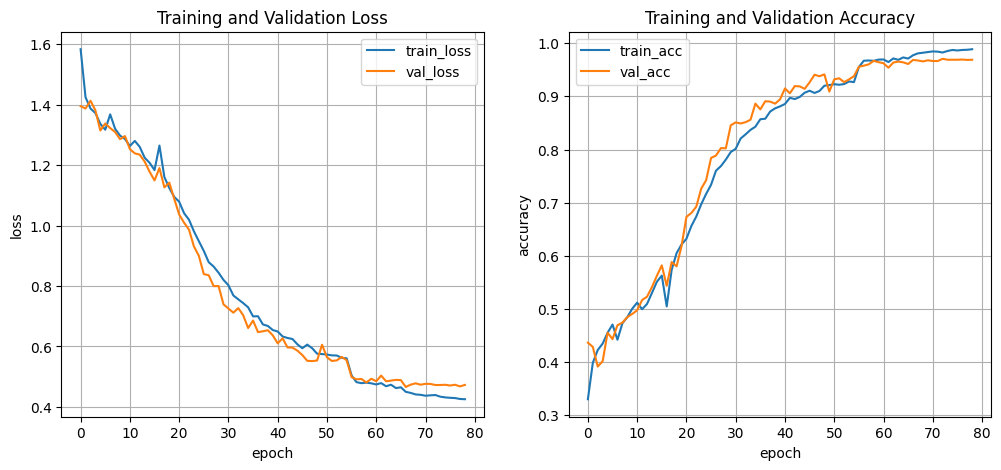

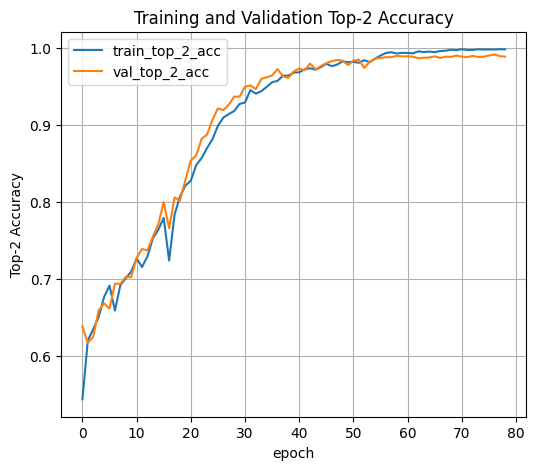


--- Evaluating Best Model on Validation Set ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'patch_embed', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'swin_block', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'swin_block_1', however the layer does not 

Best model loaded successfully!
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━

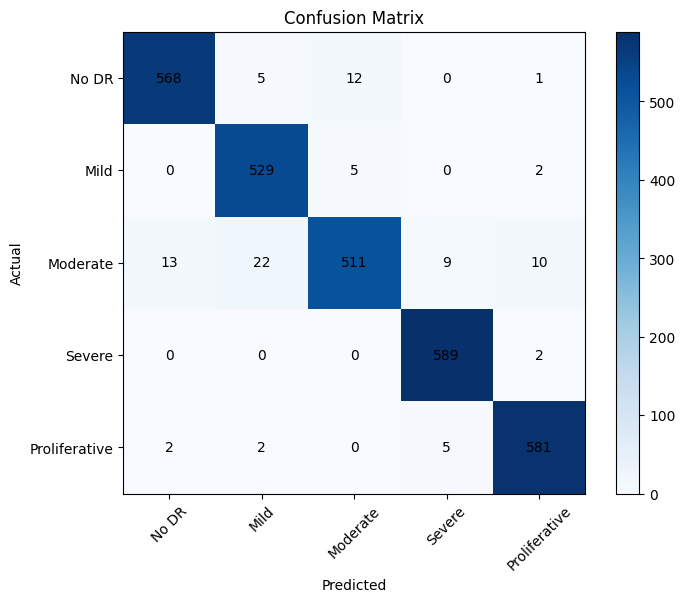

In [9]:
plot_history(history)
# To load a model with custom layers, we must provide a dictionary
# mapping the layer names to their class definitions.
custom_objects = {
    "DropPath": DropPath,
    "PatchEmbed": PatchEmbed,
    "WindowAttention": WindowAttention,
    "SwinBlock": SwinBlock,
    "PatchMerging": PatchMerging,
}

print("\n--- Evaluating Best Model on Validation Set ---")
best_model = keras.models.load_model('best_swin_model.keras', custom_objects=custom_objects)
print("Best model loaded successfully!")
evaluate_and_report(best_model, val_ds, class_names=['No DR','Mild','Moderate','Severe','Proliferative'])

In [10]:
from sklearn.metrics import roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

def advanced_evaluation_and_roc(model, dataset, class_names):
    """
    Performs an advanced evaluation, calculating per-class sensitivity and specificity,
    and plots the multi-class ROC curve.
    """
    print("--- Starting Advanced Evaluation ---")

    # --- 1. Get Predictions (Probs and Classes) and True Labels ---
    y_true_one_hot = []
    y_pred_probs = []

    print("Gathering predictions and true labels from the dataset...")
    # Iterate through the dataset to get all data
    for images, labels in dataset:
        preds = model.predict(images, verbose=0)
        y_pred_probs.append(preds)
        y_true_one_hot.append(labels.numpy())

    # Concatenate all batches into single numpy arrays
    y_pred_probs = np.concatenate(y_pred_probs, axis=0)
    y_true_one_hot = np.concatenate(y_true_one_hot, axis=0)

    # Get class indices
    y_pred_classes = np.argmax(y_pred_probs, axis=1)
    y_true_classes = np.argmax(y_true_one_hot, axis=1)

    # --- 2. Calculate and Print Per-Class Metrics (Sensitivity, Specificity) ---
    print("\n--- Per-Class Performance Metrics ---")
    cm = confusion_matrix(y_true_classes, y_pred_classes)

    for i, class_name in enumerate(class_names):
        tp = cm[i, i]
        fn = np.sum(cm[i, :]) - tp
        fp = np.sum(cm[:, i]) - tp
        tn = np.sum(cm) - (tp + fn + fp)

        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

        print(f"Class: {class_name}")
        print(f"  Sensitivity (Recall): {sensitivity:.4f}")
        print(f"  Specificity:          {specificity:.4f}")
        print("-" * 35)

    # --- 3. Compute and Plot Multi-Class ROC Curve ---
    print("\n--- Generating ROC Curve ---")
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(len(class_names)):
        fpr[i], tpr[i], _ = roc_curve(y_true_one_hot[:, i], y_pred_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(10, 8))

    colors = ['blue', 'red', 'green', 'orange', 'purple']
    for i, color in zip(range(len(class_names)), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC curve for {class_names[i]} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Chance')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.title('Multi-Class Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

--- Starting Advanced Evaluation ---
Gathering predictions and true labels from the dataset...

--- Per-Class Performance Metrics ---
Class: No DR
  Sensitivity (Recall): 0.9693
  Specificity:          0.9934
-----------------------------------
Class: Mild
  Sensitivity (Recall): 0.9869
  Specificity:          0.9876
-----------------------------------
Class: Moderate
  Sensitivity (Recall): 0.9044
  Specificity:          0.9926
-----------------------------------
Class: Severe
  Sensitivity (Recall): 0.9966
  Specificity:          0.9939
-----------------------------------
Class: Proliferative
  Sensitivity (Recall): 0.9847
  Specificity:          0.9934
-----------------------------------

--- Generating ROC Curve ---


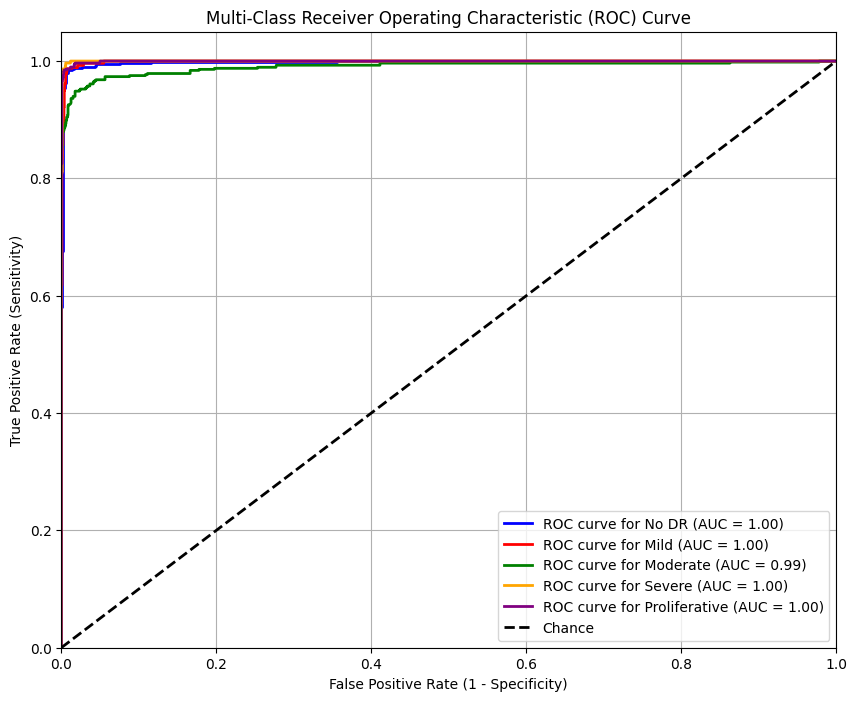

In [11]:
advanced_evaluation_and_roc(
    best_model,
    val_ds,
    class_names=['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative']
)

In [13]:
import shutil
import os
source_model_path = "best_swin_model.keras"

destination_folder = "/content/drive/MyDrive/Colab_Datasets/"
destination_model_path = os.path.join(destination_folder, "best_swin_model.keras")
os.makedirs(destination_folder, exist_ok=True)
shutil.move(source_model_path, destination_model_path)
print(f"Model successfully moved from '{source_model_path}' to '{destination_model_path}'")

Model successfully moved from 'best_swin_model.keras' to '/content/drive/MyDrive/Colab_Datasets/best_swin_model.keras'
